# Tensorflow to Tensorflow Lite

In this notebook, I try to create a simple image recognition network in order to then covert it to TF Lite to compare results.
The original network is tested and saved, with tf.saved_model.save. It is recommended to use this rather than the Keras API when trying to convert the model to TF Lite.
So far, the model is very accurate in the classical version, it works and predicts with the Lite version too. 


Currently it uses a loop to predict the every img of the test set 1 by 1, there must be a more efficient way to do so.

## 1. Tensorflow normal model

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time

from keras.models import Sequential
from keras.layers import Dense, Flatten

#### Model definition

In [2]:
model1 = Sequential([
    Flatten(input_shape=(784,)),
    Dense(320, activation='relu'),
    Dense(160, activation='relu'),
    Dense(10, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam()
model1.compile(loss = 'sparse_categorical_crossentropy',
                optimizer = 'sgd',
                metrics = 'acc')



#### Data 

In [3]:
df = pd.read_csv('./mnist_data/train.csv')
df_train = df.iloc[ :35000]
df_test2 = df.iloc[35000:]
df_test= df_test2.drop('label', axis = 1)

# Has the label column
print('shape : ', df_test.shape)


X = df_train.drop('label', axis = 1)
X /= 255.0 # Normalize
#print(X.loc[0].shape)

# Label of all the images
y = df_train['label']

shape :  (7000, 784)


#### Model fit

In [4]:
# The nb of epochs doesn't matter much at the moment
model1.fit(X, y, epochs=30)


Epoch 1/30
1094/1094 [==============================] - 2s 2ms/step - loss: 0.7505 - acc: 0.8130
Epoch 2/30
1094/1094 [==============================] - 2s 2ms/step - loss: 0.3249 - acc: 0.9082
Epoch 3/30
1094/1094 [==============================] - 2s 2ms/step - loss: 0.2699 - acc: 0.9211
Epoch 4/30
1094/1094 [==============================] - 2s 1ms/step - loss: 0.2364 - acc: 0.9321
Epoch 5/30
1094/1094 [==============================] - 2s 2ms/step - loss: 0.2107 - acc: 0.9393
Epoch 6/30
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1907 - acc: 0.9463
Epoch 7/30
1094/1094 [==============================] - 2s 1ms/step - loss: 0.1724 - acc: 0.9507
Epoch 8/30
1094/1094 [==============================] - 1s 1ms/step - loss: 0.1578 - acc: 0.9551
Epoch 9/30
1094/1094 [==============================] - 1s 1ms/step - loss: 0.1444 - acc: 0.9595
Epoch 10/30
1094/1094 [==============================] - 1s 1ms/step - loss: 0.1330 - acc: 0.9631
Epoch 11/30
1094/1094 [======

In [5]:
ypreds = model1.predict(df_test)
# ypreds.shape

#### Example plot/verification

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

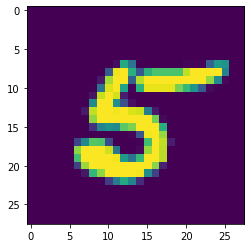

In [6]:
number = df_test.loc[35002].values
number = number.reshape(28,28)
plt.imshow(number)
ypreds[2]


### Saving the model

In [7]:
path = './model1_mnist/'
tf.saved_model.save(model1, path)

INFO:tensorflow:Assets written to: ./model1_mnist/assets


## 2. TFLite model

### First we convert it 

In [8]:
converter = tf.lite.TFLiteConverter.from_saved_model(path)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS  # enable TensorFlow ops.
]
tflite_model = converter.convert()

interpreter = tf.lite.Interpreter(model_content=tflite_model)
signatures = interpreter.get_signature_list()
print(signatures)

{'serving_default': {'inputs': ['flatten_input'], 'outputs': ['dense_2']}}


### Then we set up the interpreter
(See TFLite site)

In [9]:
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

#### Attempt to test with the same image as tested with the model network, to compare predictions.

Careful on the input/output shape. As I didn't specify the model signatures, the converter understood the input shape as [1, 784]

Note : the data type 'float32' also come from the signature, and could possibly be changed for optimization. 

In [10]:
print(input_details)
signatures = interpreter.get_signature_list()
print('signatures', signatures)

[{'name': 'serving_default_flatten_input:0', 'index': 0, 'shape': array([  1, 784], dtype=int32), 'shape_signature': array([ -1, 784], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
signatures {'serving_default': {'inputs': ['flatten_input'], 'outputs': ['dense_2']}}


In [11]:
input_shape = input_details[0]['shape']
print(input_shape)

# Is set to 0 at the beginning
print(interpreter.get_tensor(output_details[0]['index']))

test_img = df_test.loc[35002].values # is a 9 
input_data = np.array(test_img, dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data.reshape(1,784))

interpreter.invoke()

output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data) # predicts a 9 too 


[  1 784]
[[ 8.50354291e-22 -1.13418421e-38  1.39000490e+07  4.95478071e+37
   5.58918861e+11  1.24950785e-17 -1.18009355e-38  1.09663159e+18
   2.99286386e-17  1.29084721e+37]]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


In [12]:
# Deprecated 
# Is a 'slow' way to invoke the interpreter on every test image and then create a new result list. 
# Was needed when I didn't know how to change the input shape of the input tensor.
litepreds = []
for j in range(df_test.shape[0]):
    row = df_test.loc[35000+j].values
    inputimg = np.array(row, dtype=np.float32)
    interpreter.set_tensor(input_details[0]['index'], inputimg.reshape(1,784))
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    litepreds.append(output_data)

print(litepreds[5])
print(ypreds[5])
truth = np.array(litepreds == ypreds)

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


Converting the df to an array of the right data type in order to input it to the tensor

In [21]:
input_details

[{'name': 'serving_default_flatten_input:0',
  'index': 0,
  'shape': array([  1, 784], dtype=int32),
  'shape_signature': array([ -1, 784], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [13]:
testarray = df_test.to_numpy()
np.shape(testarray)
testarray = np.array(testarray, dtype=np.float32)

In [20]:

interpreter.resize_tensor_input(input_index = input_details[0]['index'],tensor_size=(7000,784) )
interpreter.allocate_tensors()

interpreter.set_tensor(input_details[0]['index'], testarray)

interpreter.invoke()

tflite_predictions = interpreter.get_tensor(output_details[0]['index'])

ValueError: cannot reshape array of size 784 into shape (7000,784)

In [15]:
np.shape(tflite_predictions)

(7000, 10)

In [16]:
a = np.argmax(tflite_predictions, axis=1)
b = np.argmax(ypreds, axis=1)
labels = df_test2.iloc[:,0].values

In [17]:
(b==labels).mean()

0.9665714285714285

Classical vs lite accuracy, will be 1 if no changes to the data type

In [18]:
(a==b).mean()

1.0